In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
!ls drive/bowl/models

albunet32.pth		starterkit2cc2.pth  starterkit_albunet.pth
albunet.pth		starterkit2cc.pth   starterkit.pth
starterkit2cc2mod1.pth	starterkit2.pth     unet16.pth


In [0]:
!mkdir bowl/

In [0]:
!mkdir bowl/stage1_train/

In [0]:
!mkdir bowl/stage1_test/

In [0]:
!unzip drive/bowl/stage1_train.zip -d bowl/stage1_train/

In [0]:
!unzip drive/bowl/stage1_test.zip -d bowl/stage1_test/

In [0]:
!pip install telepyth

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

In [0]:
import pandas as pd
import numpy as np

import cv2
import os

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

import matplotlib.pyplot as plt
import matplotlib.cm as cm  

%matplotlib inline

In [0]:
from torchvision import transforms, utils
from skimage import io, transform

In [0]:
def imshow_args(x):
    """Matplotlib imshow arguments for plotting."""
    if len(x.shape)==2: return x, cm.gray
    if x.shape[2]==1: return x[:,:,0], cm.gray
    return x, None
  
def read_image(filepath, color_mode=cv2.IMREAD_COLOR, target_size=None):
    """Read an image from a file and resize it."""
    img = cv2.imread(filepath, color_mode)
    if target_size: 
        img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)
    return img
      
def read_mask(directory, target_size=None):
    """Read and resize masks contained in a given directory."""
    for i,filename in enumerate(next(os.walk(directory))[2]):
        mask_path = os.path.join(directory, filename)
        mask_tmp = read_image(mask_path, cv2.IMREAD_GRAYSCALE, target_size)
        if not i: mask = mask_tmp
        else: mask = np.maximum(mask, mask_tmp)
    return mask 

def normalize(data, type_=1): 
    """Normalize data."""
    if type_==0:
        # Convert pixel values from [0:255] to [0:1] by global factor
        data = data.astype(np.float32) / data.max()
    if type_==1:
        # Convert pixel values from [0:255] to [0:1] by local factor
        div = data.max(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        div[div < 0.01*data.mean()] = 1. # protect against too small pixel intensities
        data = data.astype(np.float32)/div
    if type_==2:
        # Standardisation of each image 
        data = data.astype(np.float32) / data.max() 
        mean = data.mean(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        std = data.std(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        data = (data-mean)/std

    return data
  
def invert_imgs(imgs, cutoff=.5):
    '''Invert image if mean value is greater than cutoff.'''
    imgs = np.array(list(map(lambda x: 1.-x if np.mean(x)<cutoff else x, imgs)))
    return normalize(imgs)

In [0]:
def process(img_rgb):
    #green channel happends to produce slightly better results
    #than the grayscale image and other channels
    img_gray=img_rgb[:,:,1]#cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    #morphological opening (size tuned on training data)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img_open=cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, circle7)
    #Otsu thresholding
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    #Invert the image in case the objects of interest are in the dark side
    if(np.sum(img_th==255)>np.sum(img_th==0)):
        img_th=cv2.bitwise_not(img_th)
    #second morphological opening (on binary image this time)
    bin_open=cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7) 
    #connected components
    cc=cv2.connectedComponents(bin_open)[1]
    #cc=segment_on_dt(bin_open,20)
    return cc

In [0]:
class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

In [0]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)

In [0]:
class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


In [0]:
class AlbuNet(nn.Module):
    """
        UNet (https://arxiv.org/abs/1505.04597) with Resnet34(https://arxiv.org/abs/1512.03385) encoder
        Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/
        """

    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with resnet34
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.resnet34(pretrained=pretrained)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
        self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec0), dim=1)
        else:
            x_out = self.final(dec0)

        return x_out

In [0]:
from torch.utils.data import *
class DSB2018Dataset(Dataset):
    def __init__(self, root_dir, img_id, train=True, transform=None):
        """
        Args:
        :param root_dir (string): Directory with all the images
        :param img_id (list): lists of image id
        :param train: if equals true, then read training set, so the output is image, mask and imgId
                      if equals false, then read testing set, so the output is image and imgId
        :param transform (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.img_id = img_id
        self.train = train
        self.transform = transform
        self.images = [os.path.join(root_dir, train_id, 'images', train_id + '.png') for train_id in img_id]
        if train:
          self.train_masks = {train_id: [os.path.join(root_dir, train_id, 'masks', img_name) for img_name in os.listdir(os.path.join(root_dir, train_id, 'masks'))] for train_id in img_id}
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        if self.train:
            
            
            img_dir = os.path.join(TRAIN_DIR, self.img_id[idx], 'images', self.img_id[idx] + '.png')
            img = cv2.imread(img_dir)
            #img_cc = process(img)
            #img_cc = img_cc.reshape(img_cc.shape[0], img_cc.shape[1], 1)
            #img = np.concatenate((img, img_cc), axis=2)
            mask = sum((cv2.imread(train_mask)[..., 0] for train_mask in self.train_masks[self.img_id[idx]]))
            mask = np.expand_dims(mask, axis=-1)
            mask = np.expand_dims(np.swapaxes(mask, 2, 0), 0) / 255.0
            img = np.expand_dims(np.swapaxes(img, 2, 0), 0) / 255.0
            sample = {'image': torch.FloatTensor(img), 'mask': torch.FloatTensor(mask), 'img_id':self.img_id[idx], "height":img.shape[0], "width":img.shape[1]}

        else:
            img_dir = os.path.join(self.root_dir, self.img_id[idx], 'images', self.img_id[idx] + '.png')
            img = cv2.imread(img_dir)
            #img_cc = process(img)
            #img_cc = img_cc.reshape(img_cc.shape[0], img_cc.shape[1], 1)
            #img = np.concatenate((img, img_cc), axis=2)
            img = np.expand_dims(np.swapaxes(img, 2, 0), 0) / 255.0
            size = (img.shape[0],img.shape[1])  # (Height, Weidth)
            sample = {'image': torch.FloatTensor(img), 'img_id': self.img_id[idx], "height":img.shape[0], "width":img.shape[1]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [0]:
class LossBinary:
    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        loss = self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1).float()
            jaccard_output = F.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss

In [0]:
model_path = "drive/bowl/models/"
submission_path = "drive/bowl/submissions/"
model_name = "starterkit_albunet"
model_file = model_name + '.pth'
submission_file = model_name + '.csv'

In [0]:
TRAIN_DIR = 'bowl/stage1_train/'

train_ids = os.listdir(TRAIN_DIR)
train_images = [os.path.join(TRAIN_DIR, train_id, 'images', train_id + '.png') 
                for train_id in train_ids]
train_masks = {train_id: [os.path.join(TRAIN_DIR, train_id, 'masks', img_name) 
                          for img_name in os.listdir(os.path.join(TRAIN_DIR, train_id, 'masks'))]
               for train_id in train_ids}

In [0]:
TEST_DIR = 'bowl/stage1_test/'
test_ids = os.listdir(TEST_DIR)
test_images = [os.path.join(TEST_DIR, test_id, 'images', test_id + '.png') 
                for test_id in test_ids]

image:  431b9b0c520a28375b5a0c18d0a5039dd62cbca7c4a0bcc25af3b763d4a81bec
sizes:  torch.Size([3, 256, 256])
mask:  torch.Size([1, 256, 256])
pred:  torch.Size([1, 256, 256])
IoU metric value:  0.6262121212121212


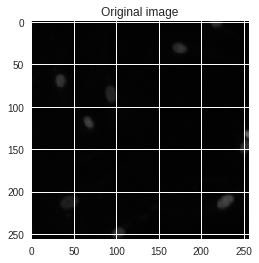

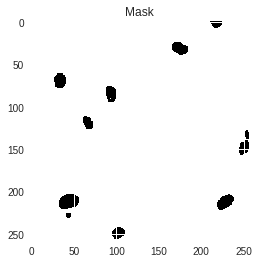

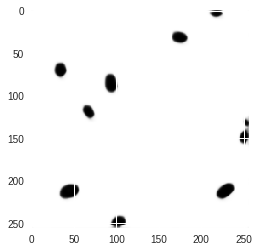

In [84]:
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

def iou_t(target, pred):
  target_y = label(target > 0.5)
  pred_y = label(pred > 0.5)
  true_objs = len(np.unique(target_y))
  pred_objs = len(np.unique(pred_y))
  intersection = np.histogram2d(target_y.flatten(),
                                pred_y.flatten(),
                                bins=(true_objs, pred_objs))[0]
  
  area_true = np.histogram(target_y, bins = true_objs)[0]
  area_pred = np.histogram(pred_y, bins = pred_objs)[0]
  area_true = np.expand_dims(area_true, -1)
  area_pred = np.expand_dims(area_pred, 0)
  
  union = area_true + area_pred - intersection
  
  intersection = intersection[1:,1:]
  union = union[1:,1:]
  union[union == 0] = 1e-9

  iou = intersection / union
  
  prec = []
  for t in np.arange(0.5, 1.0, 0.05):
    tp, fp, fn = precision_at(t, iou)
    p = tp / (tp + fp + fn)
    prec.append(p)
  return np.mean(prec)



In [0]:
def find_conventional_images(ids, _dir):
  fails = []
  for i in ids:
    img = read_image(os.path.join(_dir, i, 'images', i + '.png'))
    h = img.shape[0]
    w = img.shape[1]
    if h % 32 == 0 or w % 32 == 0: fails.append(i)
  return fails

In [0]:
train_dataset = DSB2018Dataset(root_dir = TRAIN_DIR, img_id = train_ids)

In [0]:
starter_model = nn.Sequential(nn.Conv2d(3, 16, (11, 11), padding=5),
                      nn.ReLU(),
                      nn.Conv2d(16, 16, (5, 5), padding=2),
                      nn.ReLU(),
                      nn.Conv2d(16, 1, (5, 5), padding=2),
                      nn.Sigmoid())

In [0]:
albu_model = AlbuNet(pretrained=True)

In [0]:
from telepyth import TelepythClient

In [0]:
def train(model, dataset, loss_func, name_prefix="", n_epochs=10, batch_size=16):
  
  tp = TelepythClient(token="3105941719605529941")
  tp.send_text("Training on " + name_prefix + model_name)
  
  N_EPOCHS = n_epochs
  BATCH_SIZE = batch_size

  optimizer = Adam(model.parameters(), lr=0.0005)
  model.cuda()
  model.train()
  best_loss = 9999
  losses = []
  for epoch in range(N_EPOCHS):
      report_ep = "Epoch[{}]".format(epoch)
      tp.send_text(report_ep)
      print("Epoch[{}]".format(epoch))
      b = 0
      i = 0
      avg_loss = 0
      batch_num = 0
      optimizer.zero_grad()
      for tr in dataset:
          batch_x = Variable(tr['image'].cuda())

          batch_y = Variable(tr['mask'].cuda())
          batch_y = batch_y.view(1, batch_y.size()[1], batch_y.size()[2])
        
          prediction = model(batch_x)[:, 0]

          loss = loss_func(prediction, batch_y)
          avg_loss = 0.9 * avg_loss + 0.1 * loss.data[0]
          loss = loss / BATCH_SIZE
          loss.backward()
        
          avg_loss = 0.9 * avg_loss + 0.1 * loss.data[0]
          losses.append(avg_loss)
        
          if i % BATCH_SIZE == BATCH_SIZE - 1:
              report_b = "Batch #{}; Loss:{}".format(b, avg_loss)
              if b % 20 == 0:
                tp.send_text(report_b)
              print(report_b)
              b += 1
              optimizer.step()
              i = -1
              optimizer.zero_grad()
          i += 1
      if (avg_loss < best_loss):
        best_loss = avg_loss
        report_loss = "Epoch last loss - {}. Loss improved; Model Saved as {}".format(avg_loss, model_path + name_prefix + model_file)
        torch.save(model,  model_path + name_prefix + model_file)
        tp.send_text(report_loss)
        print(report_loss)
        
      else:
        report_loss = "Epoch last loss - {}. Not an improvement".format(avg_loss)
        tp.send_text(report_loss)
        print(report_loss)
        
  report_end = "Training ended"
  print(report_end)
  tp.send_text(report_end)
  return losses

In [0]:
#_ = train(albu_model, dataset = train_dataset, loss_func = LossBinary(), n_epochs = 100, name_prefix="albu")
_ = train(starter_model, dataset = DSB2018Dataset(TRAIN_DIR, train_ids), loss_func = F.binary_cross_entropy, n_epochs = 100, name_prefix="starter")

In [0]:
albunet = torch.load(model_path + "albu" + model_file)
#starternet = torch.load(model_path + "starterkit2.pth")

In [0]:
starternet = torch.load(model_path + "starterkit2.pth")

In [0]:
test_dataset = DSB2018Dataset(TEST_DIR, test_ids, train=False)

In [0]:
from skimage.morphology import label

def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [0]:
from skimage.transform import resize
image_ids = []
rles = []
starternet.cpu()
albunet.cpu()
starternet.eval()
albunet.eval()

for test in test_dataset:
    batch_x = test['image']
    batch_x = Variable(batch_x).cuda()
    
    if test['height'] % 32 != 0 or test['width'] % 32 != 0:
      prediction = starter_model(batch_x)[0, 0].data.cpu().numpy()
    else:
      prediction = albu_model(batch_x)[0, 0].data.cpu().numpy()
    
    #prediction = model(batch_x)[0, 0].data.cpu().numpy()
    
    for rle in prob_to_rles(prediction):
        image_ids.append(test['img_id'])
        rles.append(rle)

In [0]:

submission = pd.DataFrame(data={'ImageId': image_ids,
                                'EncodedPixels': [' '.join(map(str, x)) for x in rles]})

In [0]:
submission.head(1)

,EncodedPixels,ImageId
0,6 16 262 16 518 16 774 16 1030 16 1287 14 1545...,38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990...


In [0]:
submission.to_csv(submission_path + submission_file, index=None)

In [0]:
!ls

0.csv  1.csv  bowl  data  datalab  drive  starterkit-2.csv  sub.csv


In [0]:
!cp starterkit-2.csv drive/bowl/submissions/